In [1]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#from google.colab import drive 
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
# Download images and choose a style image and a content image
path_1 = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
path_2 = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, (422, 512))
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

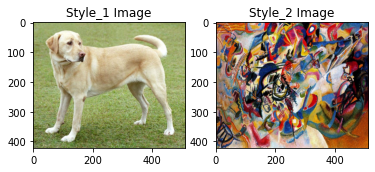

In [6]:
style_1_image = load_img(path_1)
style_2_image = load_img(path_2)

plt.subplot(1, 2, 1)
imshow(style_1_image, 'Style_1 Image')

plt.subplot(1, 2, 2)
imshow(style_2_image, 'Style_2 Image')

In [7]:
# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], [outputs])
    return model

In [8]:
# create the model:
style_layers     = ['block5_conv1']
num_style_layers = len(style_layers)

style_extractor = vgg_layers(style_layers)
style_outputs   = style_extractor(style_2_image*255)

In [9]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [10]:
class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers):
        super(StyleModel, self).__init__()
        self.vgg = vgg_layers(style_layers)
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        style_outputs = self.vgg(preprocessed_input)

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return style_dict

In [11]:
extractor = StyleModel(style_layers)
style_1_targets = extractor(style_1_image)
style_2_targets = extractor(style_2_image)

(1, 422, 512, 3)


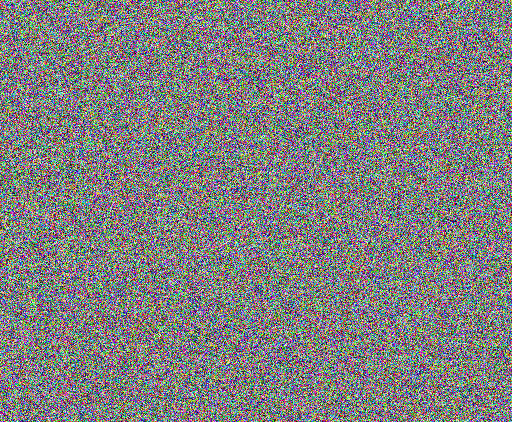

In [12]:
image = tf.Variable(tf.random.uniform(style_1_image.shape, minval=0, maxval=1))
print(image.shape)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

display.display(tensor_to_image(image))
fname = 'two_style_loss/at_%d.png' % 0
mpl.image.imsave(fname, image[0].numpy())

In [13]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_2_weight   = 1e-1
style_1_weight = 1e4

def style_loss(style_outputs):
    style_1_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_1_targets[name])**2) 
                             for name in style_outputs.keys()])
    style_1_loss *= style_1_weight / num_style_layers

    style_2_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_2_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_2_loss *= style_2_weight / num_style_layers
    
    loss = style_1_loss + style_2_loss
    return loss

In [14]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

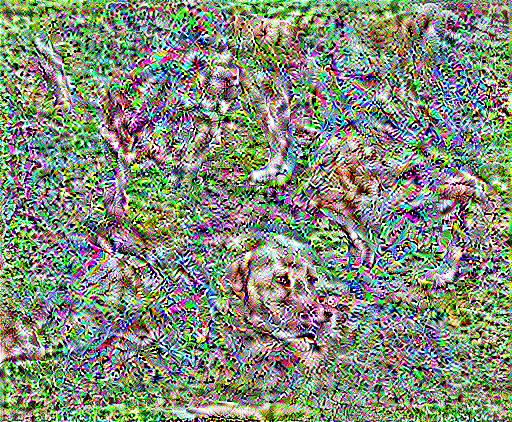

Train step: 1000
Total time: 68.5


In [15]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

    fname = 'two_style_loss/at_%d.png' % (n+1)
    mpl.image.imsave(fname, image[0].numpy())
    
end = time.time()
print("Total time: {:.1f}".format(end-start))